In [3]:
from transformers import AutoModelForTokenClassification, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType

import torch
import numpy as np

In [2]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import torch

model_id = "google/gemma-3-1b-it"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.float16
)

# Use AutoModelForCausalLM instead of AutoModelForTokenClassification
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quant_config,
    device_map="auto"
)

lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    lora_dropout=0.05, 
    bias='none',
    inference_mode=False,
    task_type=TaskType.CAUSAL_LM,
    target_modules=['o_proj', 'v_proj', "q_proj", "k_proj", "gate_proj", "down_proj", "up_proj"]
) 

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 52,183,040 || all params: 1,052,068,992 || trainable%: 4.9600


In [1]:
import transformers
print(transformers.__version__)

4.57.6


In [3]:
from gpt2vec.metrics.directionality import AttentionExtractor, SymmetryScore, DirectionalityScore

extractor = AttentionExtractor(
    model=model,
    # q_path="model.layers[layer_idx].self_attn.q_proj",
    # k_path="model.layers[layer_idx].self_attn.k_proj",
    q_path="base_model.model.model.layers[layer_idx].self_attn.q_proj",
    k_path="base_model.model.model.layers[layer_idx].self_attn.k_proj",
    attention_type="grouped",
    is_lora=True, merge_lora=True,
    is_quantized=True
)

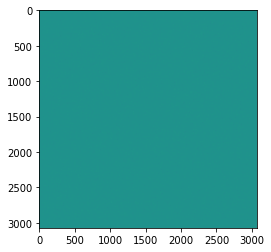

In [14]:
import matplotlib.pyplot as plt

plt.imshow(extractor.matrix(3).cpu())

In [4]:
score  = SymmetryScore(extractor)

In [5]:
res = score()

res

[-1.0,
 0.013671875,
 0.0068359375,
 0.009765625,
 0.0205078125,
 0.001953125,
 0.0205078125,
 0.0234375,
 0.056640625,
 0.025390625,
 0.0478515625,
 0.00390625,
 0.021484375,
 0.0234375,
 0.0087890625,
 0.0107421875,
 0.0048828125,
 0.0185546875,
 0.013671875,
 0.0087890625,
 0.0029296875,
 0.0029296875,
 0.0029296875,
 0.01171875,
 0.005859375,
 0.00390625,
 0.0244140625,
 0.005859375]

In [5]:
# merged lora

res

[0.013316988945007324,
 0.013686060905456543,
 0.0078051090240478516,
 0.009980559349060059,
 0.02069699764251709,
 0.0016776323318481445,
 0.02029287815093994,
 0.02415013313293457,
 0.05804133415222168,
 0.02527034282684326,
 0.04807102680206299,
 0.003994584083557129,
 0.021612167358398438,
 0.022856831550598145,
 0.009163856506347656,
 0.01067817211151123,
 0.0046149492263793945,
 0.019084453582763672,
 0.013350486755371094,
 0.009339094161987305,
 0.0028172731399536133,
 0.0029038190841674805,
 0.002758502960205078,
 0.012760281562805176,
 0.006015419960021973,
 0.004072666168212891,
 0.024454712867736816,
 0.005753040313720703]

In [6]:
np.array(res).mean()

0.014972120523452759

In [7]:
model.model.layers[0].self_attn.q_proj

Linear(in_features=3072, out_features=3072, bias=False)

In [8]:
import torch

score._score(torch.zeros_like(model.model.layers[0].self_attn.q_proj.weight))

1.0